# K-Clique

### Definition

We are given an undirected graph with vertex set $V$ and edge set $E$.

Our aim is to find out whether there exists a complete subgraph of size $K$ in this graph. 

### Applications

The Clique problem is important in areas like Bioinformatics, Computational Chemistry, Motion Segmentation and for finding structures in a graph. For example, anomalously large cliques in a network may be a sign that the underlying node connectivity is not random.

### Path to solving the problem
K-Clique can be formulated as a maximization problem and its cost function can be cast to a QUBO problem through its respective Hamiltonian (see the [Introduction](./introduction_combinatorial_optimization.ipynb) and a [reference](https://arxiv.org/abs/1302.5843)),

$$ \displaystyle \large
H = A \displaystyle \left( K - \textstyle\sum\limits_{v} x_v \right) ^2 + B \left[ \frac{K(K-1)}{2} - \textstyle\sum\limits_{uv \in E}  x_u x_v \right]
$$

where $A$ and $B$ are positive constants, $v, u \in V$ and $x_v$ is a binary variable, which is $1$ if vertex $v$ is part of the clique and $0$ if it is not. For a valid encoding, the constants $A$ and $B$ need to obey the relation $$A > B * K$$

Otherwise, if the rule is not followed, the spin configuration for the lowest energy $H$ may not correspond to the best solution of our K-Clique problem or even to a valid one. At the same time, it should not be overspecified, i.e. the left side being much bigger than the right side. If  $A$ is much larger, this would cause a large energy separation in $H$, impeding our solution approach.

The QLM allows us to encode a problem in this Hamiltonian form by using the `KClique` class for a given graph, clique size $K$ and constants $A$ and $B$. We can then create a job from the problem and send it to a heuristic Simulated Quantum Annealer (SQA)  wrapped inside a Quantum Processing Unit (QPU). The SQA will minimize the Hamiltonian, hence find the best solution to our K-Clique problem.

For a more detailed explanation and a step-by-step guidance, please follow the sections below.

### Quantum resources

To represent the problem as QUBO the QLM would need $N$ spins for each of the $N$ vertices. 

# Example problem

Imagine we are given a graph with $6$ vertices and $7$ edges, as shown below (left) and we want to find a complete subgraph of size $K = 3$. For this problem, the solution is straightforward $-$ one can notice that nodes $0$, $1$ and either $2$ or $5$ constitute such a complete graph (right).

<br><img src="./k_clique_example_solution.png" style="width: 850px"><br>

However, let us describe a procedure, which will allow us to find if there are complete subgraphs of any size in whatever graph!

We will start by specifying a graph with the `networkx` library, which should give us a huge scope for graph exploration.  One can also choose the size $K$ of the desired subgraph and the constants $A$ and $B$ accordingly.

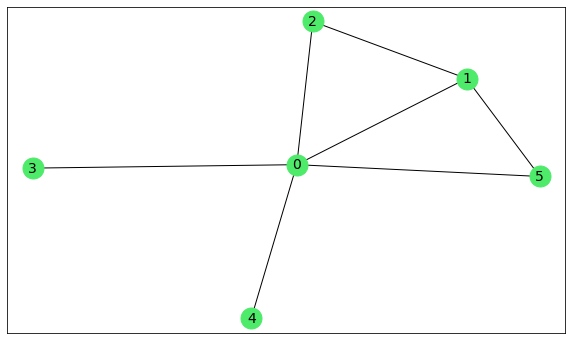

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Specify the graph 
# First example
graph = nx.Graph()
graph.add_nodes_from(np.arange(5))
graph.add_edges_from([(0, 1), (0, 2), (0, 3), (0, 4),
                      (0, 5), (1, 2), (1, 5)])

# # Second example - one may try with K = 5 or 6
# graph = nx.gnm_random_graph(15, 65)

# Specify the size of the desired subgraph
K = 3

# Impose constraints for the right encoding
B = 1
A = B * K + 1

# Draw the graph
nodes_positions = nx.spring_layout(graph, iterations=len(graph.nodes())*60)
plt.figure(figsize=(10, 6))
nx.draw_networkx(graph, 
                 pos=nodes_positions, 
                 node_color='#4EEA6A', 
                 node_size=440, 
                 font_size=14)
plt.show()

To encode the problem as QUBO, we will call the `KClique` class.

In [2]:
from qat.opt import KClique

kclique_problem = KClique(graph, K, A, B)

# Solution

We can now proceed to compute the solution of the problem by following the steps:

1. Extract the best SQA parameters found for K-Clique by calling the method `get_best_parameters()`.

    The number of Monte Carlo updates is the total number of updates performed for each temperature (and gamma) on the spins of the equivalent 2D classical system. These updates are the product of the number of annealing steps $-$ `n_steps`, the number of "Trotter replicas" $-$ `n_trotters`, and the problem size, i.e. the number of qubits needed. Hence, we can use these parameters to get the best inferred value for `n_steps`. In general, the more these steps are, the finer and better the annealing will be. However this will cause the process to take longer to complete.
    
    Similarly for the `n_trotters` field in `SQAQPU` $-$ the higher it is, the better the final solution could be, but the more time taken by the annealer to reach an answer.


2. Create a temperature and a gamma schedule for the annealing.

    We use the extracted max and min temperatures and gammas to create a (linear) temperature and a (linear) gamma schedule. These schedules evolve in time from higher to lower values since we simulate the reduction of temperatures and magnetic fields. If one wishes to vary them it may help if the min values are close to $0$, as this will cause the Hamiltonian to reach a lower energy state, potentially closer to its ground state (where the solution is encoded).

    It should be noted that non-linear schedules may be investigated too, but for the same number of steps they could lead to a slower annealing. The best min and max values for gamma and the temperature were found for linear schedules.


3. Generate the SQAQPU and create a job for the problem. The job is then sent to the QPU and the annealing is performed.


4. Present the solution spin configuration and a list of the respective coloured vertices.


5. Show the graph with the nodes of the complete subgraph coloured.

Each spin from the solution configuration corresponds to a node from the graph at the same position. Note that if the numbering of the input nodes starts from $1$ and not from $0$, one still needs to look at the $0$th spin to extract information for this first node, numbered as $1$.

When a spin has the value of $1$, this means that the respective node should be coloured and is part of the complete subgraph.

Solution configuration: 
[ 1.  1.  1. -1. -1. -1.]

The nodes of the complete subgraph are:
[0 1 2]



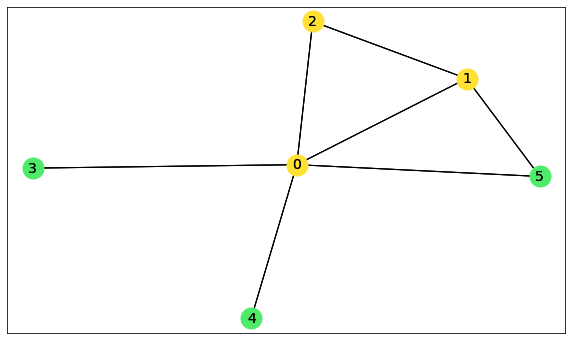

In [3]:
from qat.core import Variable
from qat.sqa import SQAQPU
from qat.sqa.sqa_qpu import integer_to_spins

# 1. Extract parameters for SQA
problem_parameters_dict = kclique_problem.get_best_parameters()
n_monte_carlo_updates = problem_parameters_dict["n_monte_carlo_updates"]
n_trotters = problem_parameters_dict["n_trotters"]
n_steps = int(n_monte_carlo_updates /
              (n_trotters * len(graph.nodes()))) # the last one is the number of spins, i.e. the problem size
temp_max = problem_parameters_dict["temp_max"]
temp_min = problem_parameters_dict["temp_min"]
gamma_max = problem_parameters_dict["gamma_max"]
gamma_min = problem_parameters_dict["gamma_min"]

# 2. Create a temperature and a gamma schedule
tmax = 1.0
t = Variable("t", float)
temp_t = temp_min * (t / tmax) + temp_max * (1 - t / tmax)
gamma_t = gamma_min * (t / tmax) + gamma_max * (1 - t / tmax)

# 3. Create a job and send it to a QPU
problem_job = kclique_problem.to_job(gamma_t=gamma_t, tmax=tmax, nbshots=1)
sqa_qpu = SQAQPU(temp_t=temp_t, n_steps=n_steps, n_trotters=n_trotters)
problem_result = sqa_qpu.submit(problem_job)

# 4. Present best configuration
state_int = problem_result.raw_data[0].state.int  # raw_data is a list of Samples - one per shot
solution_configuration = integer_to_spins(state_int, len(graph.nodes()))
print("Solution configuration: \n" + str(solution_configuration) + "\n")
indices_spin_1 = np.where(solution_configuration == 1)[0]
print("The nodes of the complete subgraph are:\n" + str(indices_spin_1) + "\n")

# 5. Show the coloured subgraph
plt.figure(figsize=(10, 6))
node_size = 440
font_size = 14
nx.draw_networkx(graph, 
                 pos=nodes_positions, 
                 nodelist=indices_spin_1.tolist(), 
                 node_color='#FFE033', 
                 node_size=node_size, 
                 font_size=font_size)

indices_spin_minus_1 = np.where(solution_configuration == -1)[0]
nx.draw_networkx(graph, 
                 pos=nodes_positions, 
                 nodelist=indices_spin_minus_1.tolist(), 
                 node_color='#4EEA6A', 
                 node_size=node_size, 
                 font_size=font_size)

nx.draw_networkx_edges(graph, pos=nodes_positions)
plt.show()

# Solution analysis

For graphs which are quite big, visual examination may be problematic. We can therefore perform a few simple checks so assess the solution. Namely, whether the subgraph found is indeed complete and indeed has $K$ nodes.

In [4]:
number_of_subgraph_nodes = len (indices_spin_1)
print("Size of the subgraph:\n" + str(number_of_subgraph_nodes))

from itertools import combinations
missing_edges_list = []
for node_1, node_2 in combinations(indices_spin_1, 2):
    if (node_1, node_2) not in graph.edges() and (node_2, node_1) not in graph.edges() :
        missing_edges_list.append((node_1, node_2))

if len(missing_edges_list) == 0:
    print ("The subgraph is complete!")
else:
    print("However, there are " + "\033[1m" + str(len(missing_edges_list)) + 
      "\033[0;0m" + " missing edges for the subgraph of this size to be complete.")
    print("They are:")
    for missing_edge in missing_edges_list: print(missing_edge)

Size of the subgraph:
3
The subgraph is complete!
